# Sigma_intrinsic Analysis
We introduce one parameter $\sigma_{intrinsic}$ in our spline model because the error bar of the gateway data do not properly describe the extra noise introduced by sampling on highly-fluctuating quasar light curve. The $\sigma_{intrinsic}$ enlarge the error bar by $\sigma_{new}=\sqrt{\sigma_{data}^2+\sigma_{intrinsic}^2}$
In this notebook, I am going to show how log-likelihood change given different $\sigma_{intrinsic}$. 


##  All data analysis

First, we'll import `SLTimer`, as well as a few other important commands. 

In [11]:
from __future__ import print_function
import os, urllib, numpy as np
%matplotlib inline
import desc.sltimer

%load_ext autoreload
%autoreload 2

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/__init__.py:1155: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Data Munging

Start a timer object, download some data to use, and plot the data. 

True Time delay 

Note: -1 comes from different time delay difinition between TDC2 and PyCS.

In [12]:
truthurl = "http://www.slac.stanford.edu/~pjm/LSST/DESC/SLTimeDelayChallenge/release/tdc2/gateway/gatewaytruth.txt"
truthfile = truthurl.split('/')[-1]
if not os.path.isfile(truthfile):
    urllib.urlretrieve(truthurl, truthfile)
d = np.loadtxt(truthfile).transpose()
truth = d[0][1]
print("True Time Delays:", -1*truth)

True Time Delays: -39.1


Downloaded datafile: http://www.slac.stanford.edu/~pjm/LSST/DESC/SLTimeDelayChallenge/release/tdc2/gateway/tdc2-gateway-2.txt
Checking header of "tdc2-gateway-2.txt"...
Reading "tdc2-gateway-2.txt"...
[Image/A] with 1014 points imported (0 of them masked).
Checking header of "tdc2-gateway-2.txt"...
Reading "tdc2-gateway-2.txt"...
[Image/B] with 1014 points imported (0 of them masked).
whiten: before whitening, means = {'A': 21.332139503633996, 'B': 21.05974099147501}
whiten: before whitening, scatters = {'A': 0.84208267217182786, 'B': 0.74641686620521042}
whiten: detected bands: ['g' 'i' 'r' 'u' 'y' 'z']
whiten: after whitening, means = {'A': 21.332139503633964, 'B': 21.059740991475003}
whiten: after whitening, scatters = {'A': 0.77703046252446539, 'B': 0.7417660365342299}


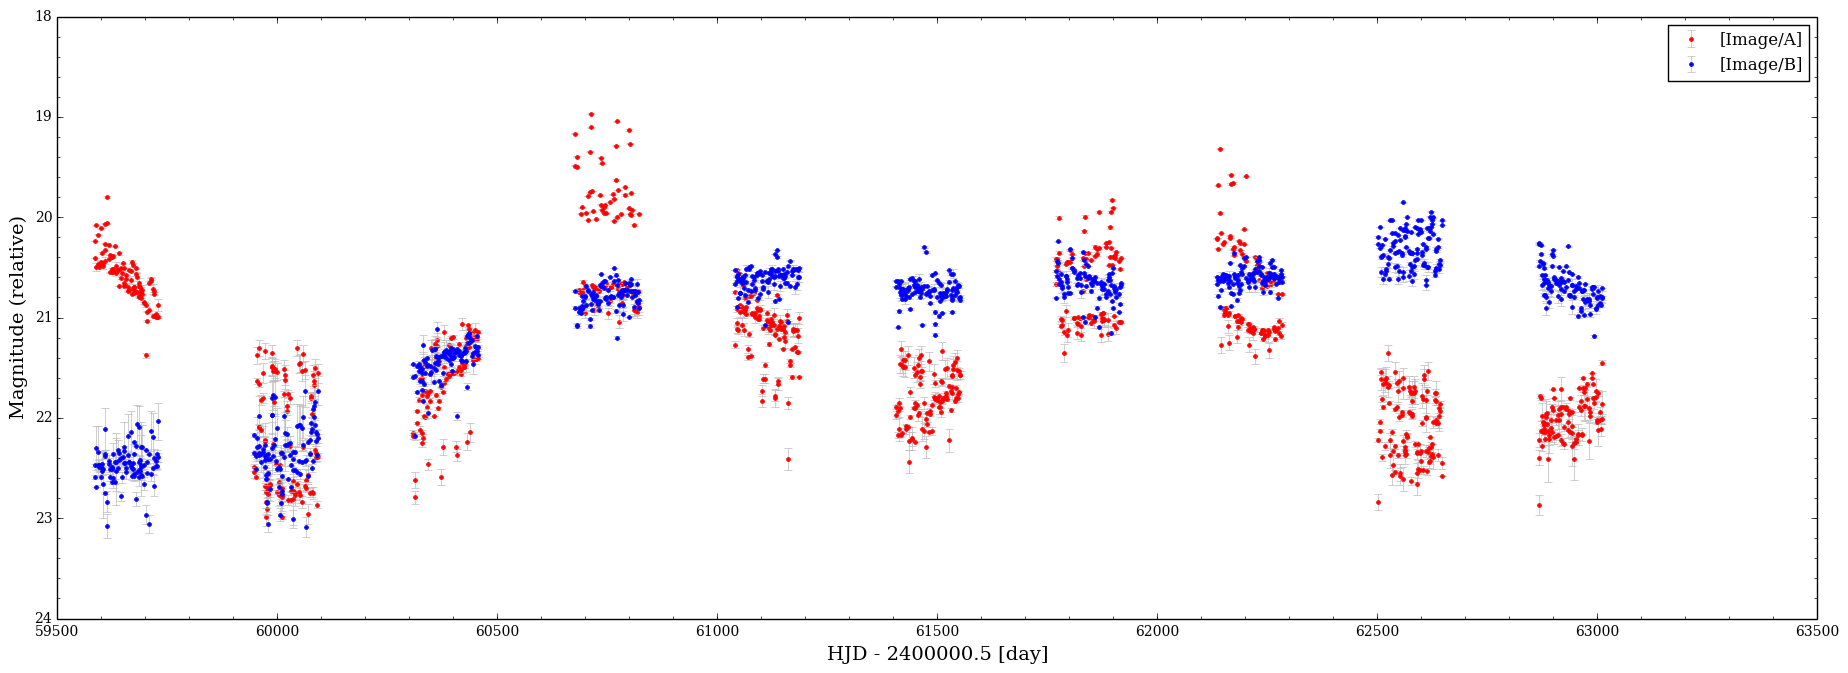

In [13]:
timer = desc.sltimer.SLTimer()
url = "http://www.slac.stanford.edu/~pjm/LSST/DESC/SLTimeDelayChallenge/release/tdc2/gateway/tdc2-gateway-2.txt"
timer.download(url, and_read=True, format='tdc2')
timer.whiten(seasonal=False)
timer.display_light_curves()
name_data="Gateway_2_ml350_all_50_delay_chi2_1000_samples.txt"
SampleUrl="http://stanford.edu/~chto/SLTimer_TDC2_Nolensing_number_of_Knots_test/GateWay2/"

In [14]:
timer.ml_knotstep=350
timer.knotstep=50

In [15]:
import os, urllib
def getFile(knotstep):
    name=name_data.format(knotstep)
    url=SampleUrl+name
    urllib.urlretrieve(url, name)
def plot_file(timer, knotstep, batch_sigma=False, method="plot_log_file"):
    name=name_data.format(knotstep)
    print(name)
    timer.plot_likelihood_from_file(name, outName="", chisquare=True, bins=200,corner_plot=False, add_prior=True, batch_sigma=batch_sigma, method=method)
def batch_analyze(timer, knotstep, batch_sigma=False, download=True, method="plot_log_file"):
    timer.knotstep=knotstep
    timer.ml_knotstep=350
    if download:
        getFile(knotstep)
    plot_file(timer, knotstep, batch_sigma=batch_sigma, method=method)
    print("degree of freedom is : {0}".format(timer.degree_of_freedom()))
def plot_light_curve(timer, delay, knotstep,jdrange=(59500,63100)):
    timer.knotstep=knotstep
    lcs, agn = timer.compute_chisq(delay=[delay], getlcs=True)
    timer.display_light_curves(given_curve=(lcs,agn),jdrange=jdrange)
def combile_sigma_File(fileArray, outName):
    with open(outName, 'w') as outfile:
        for index,fname in enumerate(fileArray):
            with open(fname) as infile:
                for line in infile:
                    if index!=0:
                        if line[0]=='#':
                            continue
                    outfile.write(line)

get likelihood files

In [16]:
name_data_original="Gateway_2_Rescaled_{0}_ml350_all_50_delay_chi2_1000_samples.txt"
for sigma in [0,0.2,0.02,0.002,0.0002]:
    name_data=name_data_original.format(sigma)
    getFile(knotstep=50)

In [17]:
combile_sigma_File(fileArray=["Gateway_2_Rescaled_0_ml350_all_50_delay_chi2_1000_samples.txt",
                              "Gateway_2_Rescaled_0.2_ml350_all_50_delay_chi2_1000_samples.txt",
                              "Gateway_2_Rescaled_0.02_ml350_all_50_delay_chi2_1000_samples.txt",
                              "Gateway_2_Rescaled_0.002_ml350_all_50_delay_chi2_1000_samples.txt",
                              "Gateway_2_Rescaled_0.0002_ml350_all_50_delay_chi2_1000_samples.txt"], 
                   outName='combined.txt')

combined log likelihood

combined.txt


/Users/chto/Projects/lsst/code/SLTimer/python/desc/sltimer/worker.py:152: RuntimeWarning: divide by zero encountered in log
  log_prior[:, 1] = np.log(prior)
/Users/chto/Projects/lsst/code/SLTimer/python/desc/sltimer/worker.py:582: RuntimeWarning: invalid value encountered in divide
  ax.step(bincentres, wd/counts, where='mid', color=color,


[ 59587.69999904  59587.70000077  59587.72999993 ...,  63012.38999957
  63012.40999998  63012.4100001 ]
[ 59587.69999904  59587.70000077  59587.72999993 ...,  63012.38999957
  63012.40999998  63012.4100001 ]
[ 59291.69999904  59295.69999904  59299.69999904 ...,  63300.4100001
  63304.4100001   63308.4100001 ]
Starting ML optimization ...
Done !
[ 59587.69999837  59587.70000045  59587.73000054 ...,  63012.39000178
  63012.4099994   63012.41000101]
[ 59587.69999837  59587.70000045  59587.73000054 ...,  63012.39000178
  63012.4099994   63012.41000101]
[ 59291.69999837  59295.69999837  59299.69999837 ...,  63300.41000101
  63304.41000101  63308.41000101]
[ 59587.69999983  59587.7000012   59587.72999981 ...,  63012.38999951
  63012.40999911  63012.41000001]
[ 59587.69999983  59587.7000012   59587.72999981 ...,  63012.38999951
  63012.40999911  63012.41000001]
[ 59291.69999983  59295.69999983  59299.69999983 ...,  63300.41000001
  63304.41000001  63308.41000001]
[ 59567.70000016  59567.73000

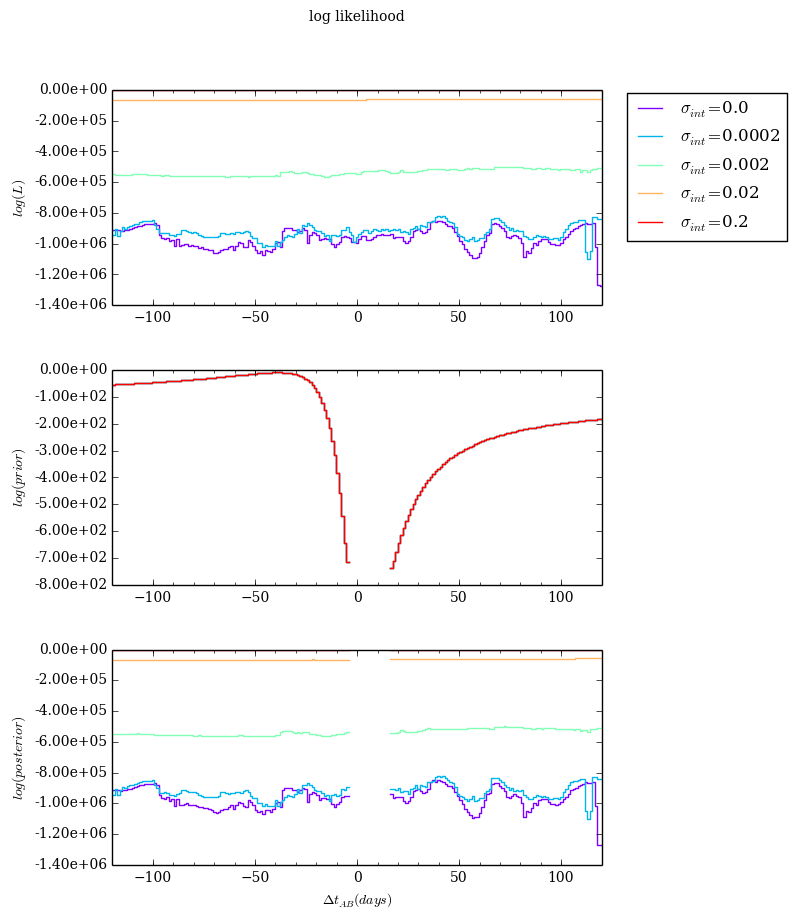

In [18]:
name_data="combined.txt"
batch_analyze(timer, knotstep=50, batch_sigma=True, download=False)

Sigma_init = 0.2 is too large for this figure, so I plot it individually.

Gateway_2_Rescaled_0.2_ml350_all_50_delay_chi2_1000_samples.txt
2.7801125635
30.1735529565
2.30391774217
[ 59563.70000066  59563.72999956  59566.00000157 ...,  63031.52999973
  63033.38999978  63033.40999961]
[ 59563.70000066  59563.72999956  59566.00000157 ...,  63031.52999973
  63033.38999978  63033.40999961]
[ 59267.70000066  59271.70000066  59275.70000066 ...,  63321.40999961
  63325.40999961  63329.40999961]
Starting ML optimization ...
Done !
[ 59563.70000069  59563.72999981  59565.99999996 ...,  63031.529999
  63033.39000123  63033.40999989]
[ 59563.70000069  59563.72999981  59565.99999996 ...,  63031.529999
  63033.39000123  63033.40999989]
[ 59267.70000069  59271.70000069  59275.70000069 ...,  63321.40999989
  63325.40999989  63329.40999989]
[ 59563.69999972  59563.72999937  59565.99999835 ...,  63031.53000155
  63033.38999968  63033.40999978]
[ 59563.69999972  59563.72999937  59565.99999835 ...,  63031.53000155
  63033.38999968  63033.40999978]
[ 59267.69999972  59271.6999997

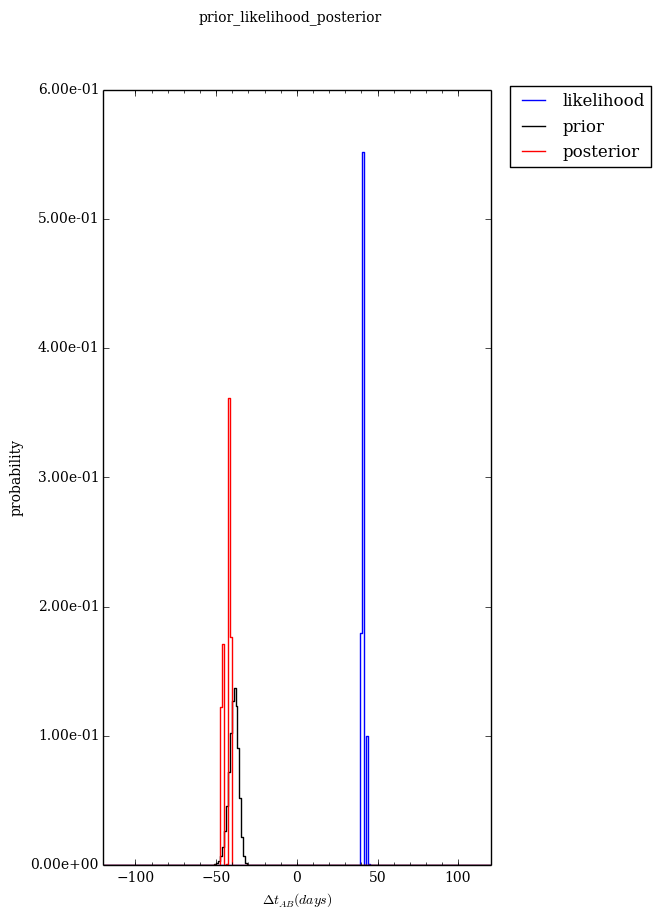

In [19]:
name_data="Gateway_2_Rescaled_0.2_ml350_all_50_delay_chi2_1000_samples.txt"
batch_analyze(timer, knotstep=50, method="plot exp in same graph")

Gateway_2_Rescaled_0.2_ml350_all_50_delay_chi2_1000_samples.txt


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/axes.py:4747: UserWarning: No labeled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labeled objects found. "


[ 59544.69999914  59544.73000031  59546.99999979 ...,  63049.53000296
  63051.39000057  63051.40999934]
[ 59544.69999914  59544.73000031  59546.99999979 ...,  63049.53000296
  63051.39000057  63051.40999934]
[ 59248.69999914  59252.69999914  59256.69999914 ...,  63339.40999934
  63343.40999934  63347.40999934]
Starting ML optimization ...
Done !
[ 59544.70000074  59544.72999918  59547.00000096 ...,  63049.53000046
  63051.38999963  63051.41000074]
[ 59544.70000074  59544.72999918  59547.00000096 ...,  63049.53000046
  63051.38999963  63051.41000074]
[ 59248.70000074  59252.70000074  59256.70000074 ...,  63339.41000074
  63343.41000074  63347.41000074]
[ 59544.70000122  59544.72999822  59546.99999828 ...,  63049.53000062
  63051.38999951  63051.41000003]
[ 59544.70000122  59544.72999822  59546.99999828 ...,  63049.53000062
  63051.38999951  63051.41000003]
[ 59248.70000122  59252.70000122  59256.70000122 ...,  63339.41000003
  63343.41000003  63347.41000003]
[ 59524.69999986  59524.7300

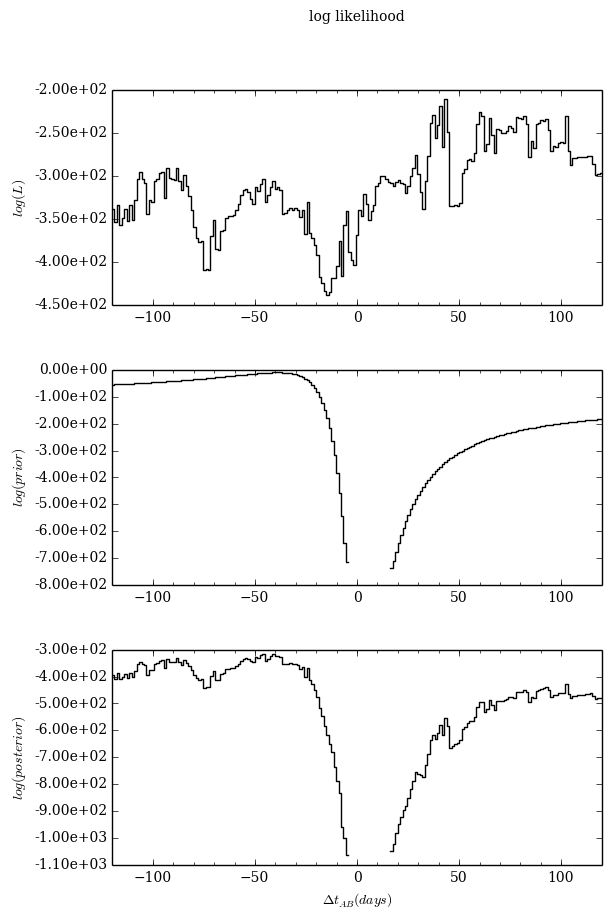

In [20]:
name_data="Gateway_2_Rescaled_0.2_ml350_all_50_delay_chi2_1000_samples.txt"
batch_analyze(timer, knotstep=50)

To compare I plot sigma=0

Gateway_2_Rescaled_0_ml350_all_50_delay_chi2_1000_samples.txt
[ 59520.69999955  59520.73000136  59522.99999952 ...,  63053.53000015
  63055.38999914  63055.40999916]
[ 59520.69999955  59520.73000136  59522.99999952 ...,  63053.53000015
  63055.38999914  63055.40999916]
[ 59224.69999955  59228.69999955  59232.69999955 ...,  63343.40999916
  63347.40999916  63351.40999916]
Starting ML optimization ...
Done !
[ 59520.70000091  59520.72999968  59523.00000218 ...,  63053.53000151
  63055.39000029  63055.41000084]
[ 59520.70000091  59520.72999968  59523.00000218 ...,  63053.53000151
  63055.39000029  63055.41000084]
[ 59224.70000091  59228.70000091  59232.70000091 ...,  63343.41000084
  63347.41000084  63351.41000084]
[ 59520.70000118  59520.72999766  59522.99999937 ...,  63053.52999743
  63055.39000128  63055.41000129]
[ 59520.70000118  59520.72999766  59522.99999937 ...,  63053.52999743
  63055.39000128  63055.41000129]
[ 59224.70000118  59228.70000118  59232.70000118 ...,  63343.41000129


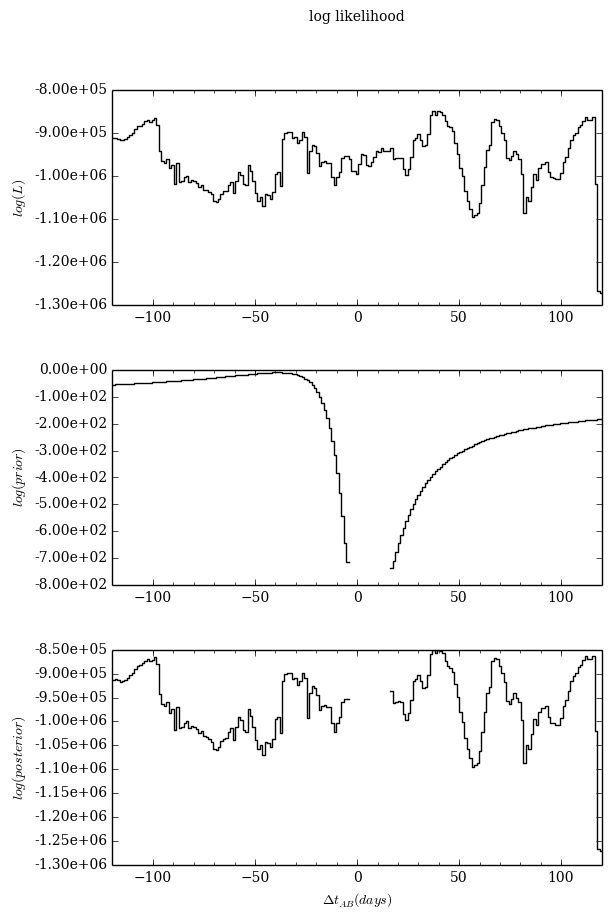

In [21]:
name_data="Gateway_2_Rescaled_0_ml350_all_50_delay_chi2_1000_samples.txt"
batch_analyze(timer, knotstep=50)

Another way to see this is to plot likelihood to sigma diagram given true time delay

In [22]:
def get_loglikelihood(timer, sigma, delay):
    timer = desc.sltimer.SLTimer()
    timer.download(url, and_read=True, format='tdc2')
    timer.whiten(seasonal=False)
    timer.sigma_intrinsic = sigma
    timer.rescale_noise()
    chisquare=timer.chisquare_to_loglikelihood(timer.compute_chisq([delay], batch=False, getlcs=False))
    timer.reset_noise() 
    return chisquare

In [32]:
sigma_Array=np.logspace(-2,0,50)
delays=[-40,-30,-20,-10,0,10,20,30,40]
likelihoodResult={}
for delay in delays:
    likelihood=[]
    newsigmaArray=[]
    for sigma in sigma_Array:
        try:
            likelihood.append(get_loglikelihood(timer, sigma, delay))
            newsigmaArray.append(sigma)
        except:
            print(sigma, "\n")
            continue
    likelihoodResult[delay]=[newsigmaArray, likelihood]
np.save("likelihoodResult.npy", likelihoodResult)

Downloaded datafile: http://www.slac.stanford.edu/~pjm/LSST/DESC/SLTimeDelayChallenge/release/tdc2/gateway/tdc2-gateway-2.txt
Checking header of "tdc2-gateway-2.txt"...
Reading "tdc2-gateway-2.txt"...
[Image/A] with 1014 points imported (0 of them masked).
Checking header of "tdc2-gateway-2.txt"...
Reading "tdc2-gateway-2.txt"...
[Image/B] with 1014 points imported (0 of them masked).
whiten: before whitening, means = {'A': 21.332139503633996, 'B': 21.05974099147501}
whiten: before whitening, scatters = {'A': 0.84208267217182786, 'B': 0.74641686620521042}
whiten: detected bands: ['g' 'i' 'r' 'u' 'y' 'z']
whiten: after whitening, means = {'A': 21.332139503633964, 'B': 21.059740991475003}
whiten: after whitening, scatters = {'A': 0.77703046252446539, 'B': 0.7417660365342299}
add additional noise 0.01
Starting ML optimization ...
Working on the spline ML of [Image/A]|~3/u/8~|
Working on the spline ML of [Image/B](-40.000,0.608,0)|~3/u/8~|
Done !
Starting ML optimization ...
Working on the

[0, -30, 40, 10, -20, 20, -10, -40, 30]
0.01
0
1
2
3
4
5
6
7
8


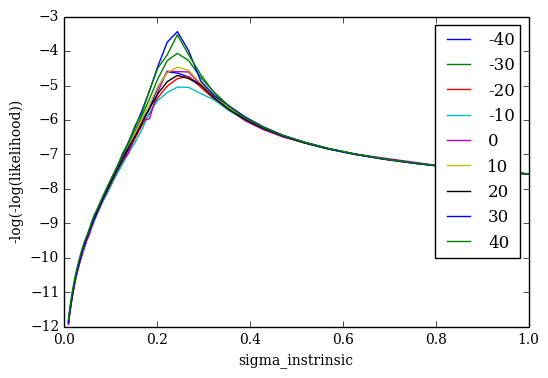

In [45]:
print(likelihoodResult.keys())
from matplotlib import pyplot as plt
print(min(sigma_Array))
for number, delay in enumerate(delays):
    print(number)
    likelihood_delay=np.array(likelihoodResult[delay])
    plt.plot(likelihood_delay[0], -np.log(-likelihood_delay[1]),"-", label=str(delay))
plt.ylabel("-log(-log(likelihood))")
plt.xlabel('sigma_instrinsic')
plt.legend()

We see the peak is at 0.2, which is consitant with what we saw.

Conclusion:
1. sigma=0.2 do improve the fitting. 
2. the posterior  of sigma =0.2 recover the true time delay
3. I am still worried about why the likelihood for sigma=0.2 do not recover the true time delay (In fact even get worse compring to sigma=0)